**Members:**
1. Tan Chien Yuan (29940729)
2. Alex Hew Hoong-Ming (21111359)

# Project Context

## Model
There are many possible approaches to combat SadTalker's fake videos. After some research, we chose video classification. One reason is the possibility of generalising the technique to other types of deepfakes and fake videos. Another is that previous research shows that classification performance on deepfakes is respectable and superior to 2D CNNs (Convolutional Neural Networks) classifying individual frames. Finally, from an intuitive standpoint, SadTalker videos do not look convincing to the human eye. This should translate to decent classification performance by video classifiers.

We have chosen 3D CNNs for this task. The additional dimension compared to 2D CNNs is used for the depth or time dimension when performing convolution operations. However, state-of-the-art 3D CNNs have hardware requirements that are out of reach, needing racks of GPUs or AI processors. We need to address this to be able to train the models on our limited available hardware.

Fortunately, a paper was written on greatly improving 3D CNN efficiency while also improving on classification performance. Xie et al. (2018) experimented with different architectures, feature gating, optical flow and ensembling to greatly improve efficiency of the state-of-the-art I3D 3D CNN by Carreira and Zisserman (2017). The improved model by Xie et al. (2018) is called S3D, separable 3D CNN.

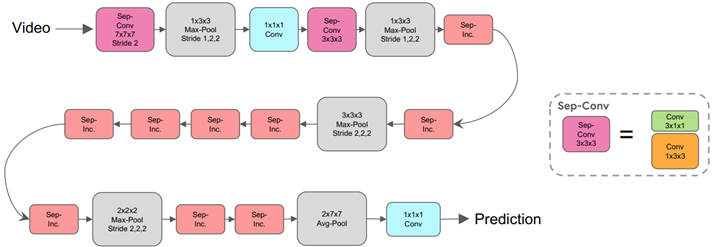

Instead of 3D convolutions, S3D uses "2+1D" convolutions which breaks 3D convolution to two parts: one 2D convolution followed by one 1D convolution in the depth/time dimension. This is both more efficient and more effective.

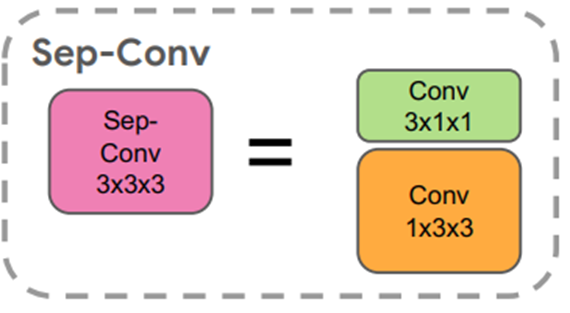

Ultimately, the authors were able to beat I3D in both effectiveness and efficiency on multiple video classification datasets.

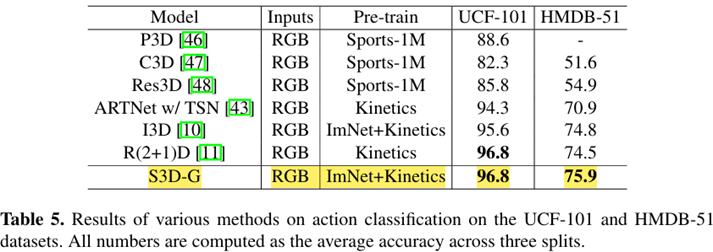

## Ensemble Learning
![Screenshot 2024-10-22 041231_70.jpg](<attachment:Screenshot 2024-10-22 041231_70.jpg>)

To further improve the detection performance, we can utilize a concept known as ensemble learning. The basic idea of ensemble learning is to have 2 or more streams of data sources. In this context we can train 2 different models each being trained on a different dataset. Then the outputs or predictions are then combined to form the final prediction. Typically there are 2 methods of combining the predictions. The first is through late fusion where the classification outputs are either averaged or a weighted sum is taken. The other method is Mid level fusion where the outputs are combined for example through concatenation and the combined output is then passed to a classifier. For our project we plan to use the late fusion method for its simplicity.





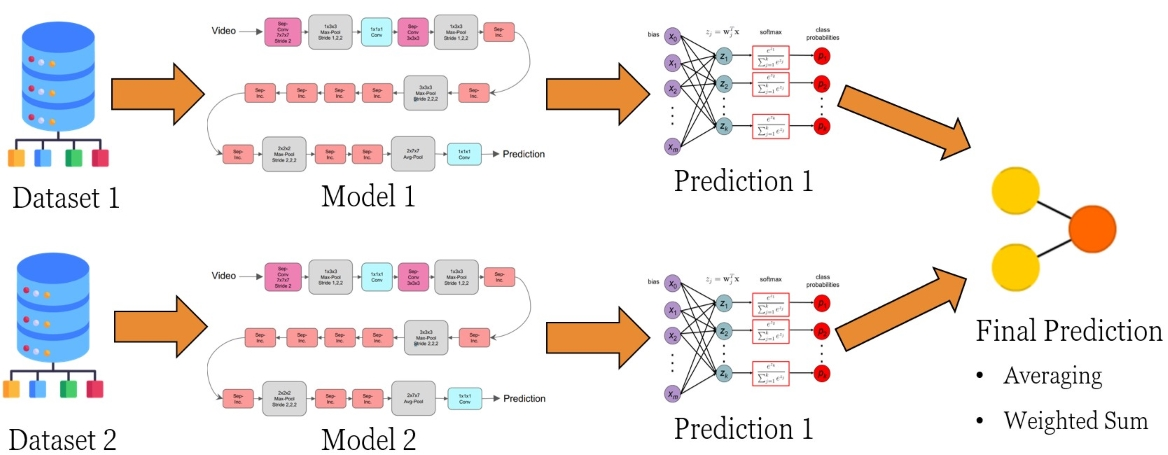

## RGB Dataset
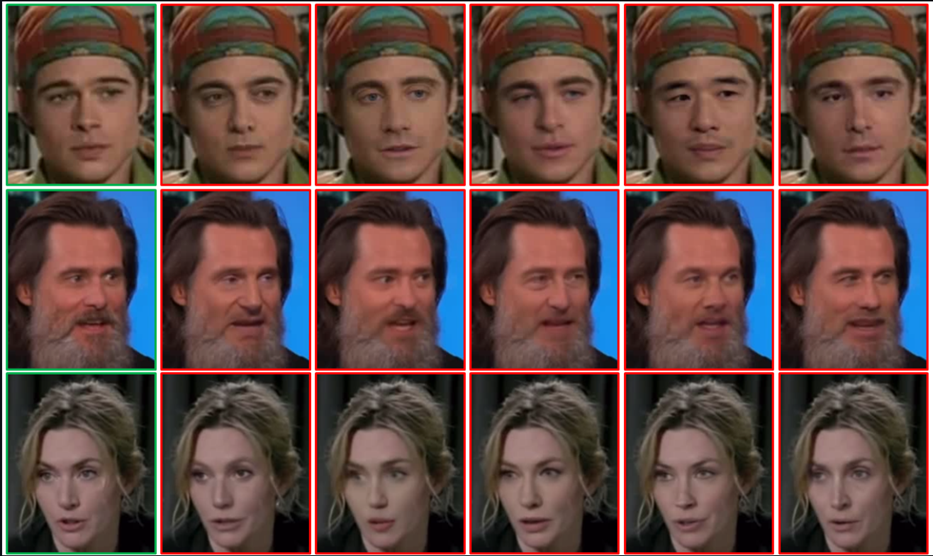

The main dataset used in this project is the **Celeb-DF** which is a large scale dataset for deep fake forensics, where the details of the dataset is listed below. This dataset will be used to train the 1st of the 2 models as mention in the ensemble learning section. In this project this 1st model is refered to as the "RGB Model". Moreover, before the dataset is passed to the model. The dataset is first pre-processed using various different methods which are listed below, where the methods are performed sequentially as shown in the list.

**Details:**
* Total Samples = 6529
* Example Resolution = 892 x 500
* Frame Rate = 30
* Real:
    * Videos downloaded from YouTube
    * 590 Celebrity videos
    * 300 Additional videos
* Fake:
    * 5639 Synthesized videos 

**Manipulation & Transforms:**
1. Clip videos to 300 frames = 10s @ 30fps
2. Sample 150 frames based on a set interval (2 in this case)
3. Convert video data to float32 which also normalizes the values to be ∈ [0,1]
4. Normalize values further based on ImageNet normalization parameters
    * Mean = (0.43216, 0.394666, 0.37645)
    * Std = (0.22803, 0.22145, 0.216989)
5. Resize to (256, 256)
6. Re-arrange to have the following dimension (batch, channel, frames, height, width)


## Flow Dataset
**RAFT**

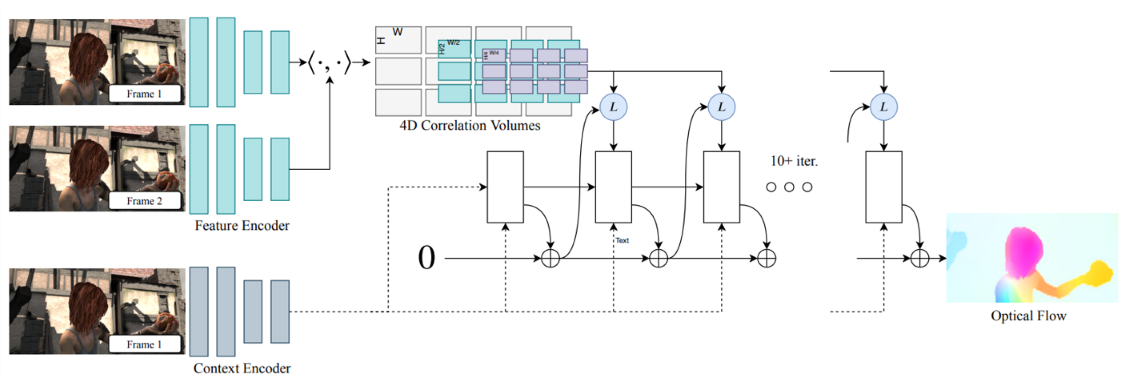

![Screenshot 2024-10-22 035356_50.jpg](<attachment:Screenshot 2024-10-22 035356_50.jpg>)

To train the 2nd model which will be refered to as the "Flow Model" another dataset is needed. The 2nd dataset is obtained by extracting the optical flow from the 1st dataset **Celeb-DF**. Optical flow is a vector field formulated on two consecutive frames f(t) and f(t+1), to extract plausible motion between the subject and the background itself. To extract the optical flow from the **Celeb-DF** dataset, we utilized a well known state of the art model known as **RAFT** which was designed specifically to extract optical flow given an input video. However, to train a **S3D** model using optical flow as input the optical flow is first converted to a rgb video. Then the optical flow in format of a rgb video is then used to train the "Flow Model". In addition, the same pre-processing done on the **Celeb-DF** dataset is also applied. Specifically, the pre-processing is performed before using **RAFT** to extract the optical flow. The list below describes the whole process in sequential order to obtain the Flow Dataset.

**Process:**
1. Clip videos to 300 frames = 10s @ 30fps
2. Sample 150 frames based on a set interval (2 in this case)
3. Convert video data to float32 which also normalizes the values to be ∈ [0,1]
4. Normalize values further based on ImageNet normalization parameters
    * Mean = (0.43216, 0.394666, 0.37645)
    * Std = (0.22803, 0.22145, 0.216989)
5. Resize to (256, 256)
6. Obtain optical flow using RAFT
7. Convert optical flow into rgb format
8. Compress the optical flow to reduce storage requirements
9. Re-arrange to have the following dimension (batch, channel, frames, height, width)
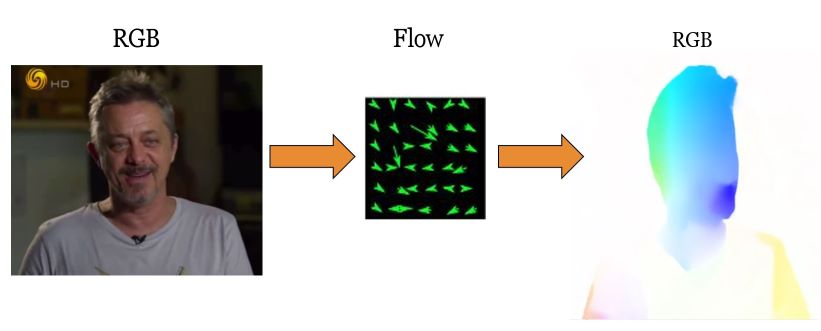

## Experiment Setup

### Dataset

Due to hardware and time constraints we are only utilizing the test set from the **Celeb-DF** dataset which consits of 518 videos out of the orginal 6529 vidoes. The optical flow dataset was also generated from this test set. Moreover, we split the data further into training set & valdiation set using a 0.9 split.

**Test Set:**
* Total Samples = 518
    * Real vidoes = 178
    * Fake vidoes = 340  
* Training set = 466
* Validation set = 52

### Model

**S3D:**
* Weights = Pre-trained weights trained on Kinetics400_V1
* Classifier replaced & set output channels = 2
* All weights not frozen

### Optimiser

**SGD with Momentum:**
* Learning rate = 0.001
* Momentum = 0.9
* Weight Decay = 0.0005

### Loss Function

**Cross Entropy Loss:**
* Weights scaled based on the class distribution by scalling them inversely proportional to the number of samples

* Formula = $[\frac{Total.sum.of.samples}{(Sum.of.samples.for.Class.0) * 2} \frac{Total.sum.of.samples}{(Sum.of.samples.for.Class.1) * 2}]$
        = $[\frac{518}{(340) * 2} \frac{518}{(178) * 2}]$

### Training

**Hyper Parameters:**
* Batch Size = 2
* Epochs = 15
* Enabled Automatic Mixed Precision (AMP)
* Aproximate training time per epoch = 12 minutes



### References
1. Carreira, J., & Zisserman, A. (2017). Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset. ArXiv.org. https://arxiv.org/abs/1705.07750
2. Xie, S., Sun, C., Huang, J., Tu, Z., & Murphy, K. (2018). Rethinking Spatiotemporal Feature Learning: Speed-Accuracy Trade-offs in Video Classification. ArXiv.org. https://arxiv.org/abs/1712.04851
3. Celeb-V2 Dataset source: https://github.com/yuezunli/celeb-deepfakeforensics 

4. De Lima, O., Franklin, S., Basu, S., Karwoski, B., & George, A. (2020). Deepfake detection using spatiotemporal convolutional networks. arXiv preprint arXiv:2006.14749. https://arxiv.org/abs/2006.14749  

5. Pytorch Automatic Mixed Precision package:
    * https://pytorch.org/docs/stable/amp.html 
    * https://pytorch.org/docs/stable/notes/amp_examples.html#typical-mixed-precision-training

6. Teed, Z., & Deng, J. (2020). Raft: Recurrent all-pairs field transforms for optical flow. In Computer Vision–ECCV 2020: 16th European Conference, Glasgow, UK, August 23–28, 2020, Proceedings, Part II 16 (pp. 402-419). Springer International Publishing. https://arxiv.org/abs/2003.12039

# Libary Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms.v2 as transforms
from torchvision.io.video import read_video
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights
import torchvision.transforms as T
from torchvision.utils import flow_to_image


from torchvision.models.video import s3d, S3D_Weights

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import metrics
import cv2
from pathlib import Path
import av

# custom libraries
from utils import *
from celebdf2 import *
from main import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the random seed for reproducibility
seed = 50  # You can choose any integer for your seed value
# Set the seed for PyTorch (CPU and CUDA)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setup
# Set the seed for Python's random module
random.seed(seed)
# Set the seed for NumPy
np.random.seed(seed)

In [ ]:
# issues:
# Resolved 1. model is not training
# Resolved 2. when batch size more than 1 need to constict the number of frames
# Resolved 3. crop a small amount then resize
# 4. train using adversial data like black box attacks (random noise)
# Resolved 5. use interval for frames after clipping
# Resolved 6. add logging & save model
# Resolved 7. not whole dataset is used currently only testing samples
# Resolved 8. save logged results in pth file
# Resolved 9. test adamw
# Resolved 10. print running loss & acc since using less epochs
# Resolved - save batch results as 2d array
# Resolved - save batch results into model file
# Resolved 12. train optical flow model - Nic
# Resolved 14. plot results - Nic
# Resolved 15. confusion matrix - Nic
# Resolved 20. save cm for trainining dataset into utils
# Resolved 21. check model loading code for inferencing
# Resolved 11. train rgb model - train v3

# 13. ensemble learning - Alex
# 16. test on sadtalker - remain rgb model, use real videos that give 100% accuracy
# 17. write descriptions for notebook from updated full ed post
# 18. tables to compile model results
# 20. display reacall,precision scores for each confusion matrix
# 21. Port all functions
# 19. video
# 22. report

# optical flow
# Resolved 1. resize to 256,256
# Resolved 2. limit frames to 10s
# Resolved 3. sample using interval 15 frames per 1s = 150 frames

# Generate Optical Flow Dataset

### Display video file example

In [5]:
dataset_path = Path('data/Celeb-DF-v2/YouTube-real')
video_path = "00000.mp4"
data_path = dataset_path / video_path

print(data_path)
# Load the video using torchvision
vid, _, _ = read_video(data_path, output_format="TCHW", pts_unit='sec')  # TCHW: Time, Channels, Height, Width
# vid = vid[:32]  # Optionally, shorten the duration if needed (e.g., first 32 frames)
print(vid.shape)

# Display the optical flow image using OpenCV
for frame in vid:
    fr = cv2.cvtColor(frame.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB)
    # print(fr.shape) # 500,892,3
    cv2.imshow('input', fr)
    # Wait for 25ms before moving to the next frame
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break  # Exit the loop if 'q' is pressed

# Release the video window
cv2.destroyAllWindows()

data\Celeb-DF-v2\YouTube-real\00000.mp4
torch.Size([450, 3, 500, 892])


### Load Raft model

In [8]:
# Load the RAFT model with pre-trained weights
raft = raft_large(weights=Raft_Large_Weights.DEFAULT).to(device)
raft.eval()

RAFT(
  (feature_encoder): FeatureEncoder(
    (convnormrelu): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (convnormrelu1): Conv2dNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
        (convnormrelu2): Conv2dNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
        (downsample): Identity()
        (relu): ReLU(inplace=True)
      )
      (1): ResidualBlock(
        (

### Flow Generation & Compression Functions

In [6]:
# Custom Dataset class for video frames
class VideoFrameDataset(Dataset):
    def __init__(self, video_path, transform):
        self.video_path = video_path
        self.vid, _, _ = read_video(video_path, output_format="TCHW", pts_unit='sec')

        # Clip frames to the fixed number `max_frames`
        self.max_frames = 300
        self.vid = self._clip_frames(self.vid)

        # sample n number of frames from clipped video
        self.n_frames = 150
        self.vid = self._sample_frames(self.vid)

        self.vid = transform(self.vid)
        # print(self.vid.shape)
    
    def __len__(self):
        return self.vid.shape[0] - 1  # Last frame has no next frame

    def __getitem__(self, idx):
        prev_frame = self.vid[idx]
        curr_frame = self.vid[idx + 1]
        return prev_frame, curr_frame
    
    def _clip_frames(self, frames):
        """Clip the video frames to a fixed number of frames `max_frames`."""
        # If the video has more frames than max_frames, clip it to the first `max_frames`
        if len(frames) > self.max_frames:
            return frames[:self.max_frames]
        
        # If the video has fewer frames than `max_frames`, pad with zeros
        pad_size = self.max_frames - len(frames)
        pad_frames = torch.zeros((pad_size, *frames.shape[1:]))  # Create padding frames with same size
        frames = torch.cat([frames, pad_frames], dim=0)
        
        return frames
    
    def _sample_frames(self, frames):
        """Sample n number of frames from cliped video"""
        if len(frames) > self.n_frames:
            indices = torch.linspace(0, len(frames)-1, steps=self.n_frames).long()
            frames = frames[indices]  
        
        return frames


# Generate Optical Flow for 1 video
def process_single_video(video_path, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the dataset
    dataset = VideoFrameDataset(video_path,preprocess)
    data_loader = DataLoader(dataset, batch_size=75, shuffle=False, num_workers=0, pin_memory=True)

    # Initialize video writer
    fps = 15  # Adjust if needed
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    # output_file = output_dir / (video_path.stem + '_flow.avi')
    output_file = "temp.avi" 
    out = cv2.VideoWriter(output_file, fourcc, fps, (256, 256)) # saves as temporary file before compression

    # Process video frames
    for prev_frames, curr_frames in data_loader:
        # Preprocess batches
        batch_prev_tensor = torch.stack([f.unsqueeze(0).to(device) for f in prev_frames]).squeeze(1)
        batch_curr_tensor = torch.stack([f.unsqueeze(0).to(device) for f in curr_frames]).squeeze(1)
        # print(batch_prev_tensor.shape)

        with torch.no_grad(): 
            with torch.autocast(device_type="cuda"):
                # Predict optical flows
                flow_list = model(batch_prev_tensor, batch_curr_tensor)
                predicted_flows = flow_list[-1]  # Final output

        # Convert optical flows to RGB and write to video
        for flow in predicted_flows:
            flow_image = flow_to_image(flow.squeeze(0)).cpu().numpy().transpose(1, 2, 0)  # (496, 888, 3)
            flow_image_bgr = cv2.cvtColor(flow_image.astype(np.uint8), cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
            out.write(flow_image_bgr)

        # # Clear tensors and free memory
        # del batch_prev_tensor, batch_curr_tensor, flow_list, predicted_flows
        # torch.cuda.empty_cache()

    # Release resources
    out.release()

# Compress the generated Optical Flow video to a target bitrate
def compress_video(input_file, output_file, target_bitrate=500000):
    # Open the input file
    input_container = av.open(input_file)
    
    # Create an output container to write the compressed video
    output_container = av.open(output_file, mode='w')

    # Set codec for the output video stream (e.g., H.264)
    output_stream = output_container.add_stream('h264', rate=15)  # 30 fps

    # Set the bitrate for compression
    output_stream.bit_rate = target_bitrate  # Bitrate in bits per second

    # Set the resolution of the output video stream based on the input stream
    output_stream.width = 256
    output_stream.height = 256

    for frame in input_container.decode(video=0):
        # Re-encode the frames to the output video stream
        packet = output_stream.encode(frame)
        if packet:
            output_container.mux(packet)

    # Flush any remaining packets
    output_container.mux(output_stream.encode())
    
    # Close the containers
    input_container.close()
    output_container.close()

    # print(f"Video compressed successfully to: {output_file}")

# function to generate optical flow for all videos in a folder
def process_videos_in_folder(folder_path, model, output_dir):
    video_paths = sorted(Path(folder_path).glob('*.mp4'))  # Assumes .mp4, adjust if necessary
    output_dir.mkdir(parents=True, exist_ok=True)

    for video_path in video_paths:
        # print(f"Processing video: {video_path}")
        process_single_video(video_path, model)

        # Optionally compress the video after processing
        input_vid = "temp.avi"
        compressed_output_file = output_dir / (video_path.stem + '.mp4')
        compress_video(input_vid, compressed_output_file, target_bitrate=1500000)


# define preprocess transforms for video dataset class
preprocess = T.Compose([
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=(0.43216, 0.394666, 0.37645),
                std=(0.22803, 0.22145, 0.216989)),
    T.Resize([256, 256]),
])


### Process Videos from Specified Folder

In [ ]:
folder_path = Path('H:/Datasets/maliciousai/data/Celeb-DF-v2/YouTube-real')
output_dir = Path('H:/Datasets/maliciousai/data/Celeb-DF-v2-Flow/YouTube-real')

# folder_path = Path('H:/Datasets/maliciousai/data/Celeb-DF-v2/Celeb-real')
# output_dir = Path('H:/Datasets/maliciousai/data/Celeb-DF-v2-Flow/Celeb-real')

# folder_path = Path('H:/Datasets/maliciousai/data/Celeb-synthesis')
# output_dir = Path('H:/Datasets/maliciousai/data/Celeb-DF-v2-Flow/Celeb-synthesis')

process_videos_in_folder(folder_path, raft, output_dir) # 3.8s per video

# Train S3D Models

### Visualize S3D Model

In [6]:
# Visualize S3D model with pre-trained weights
model = s3d(weights=S3D_Weights.DEFAULT)
model.eval()

S3D(
  (features): Sequential(
    (0): TemporalSeparableConv(
      (0): Conv3dNormActivation(
        (0): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
        (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv3dNormActivation(
        (0): Conv3d(64, 64, kernel_size=(7, 1, 1), stride=(2, 1, 1), padding=(3, 0, 0), bias=False)
        (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (2): Conv3dNormActivation(
      (0): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): TemporalSeparableConv(
      (0): Conv3d

### Grid Search Optimal Sample Size

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data/Celeb-DF-v2"
batch_size = 3 
epochs = 1
train_s3d(dataset_path,batch_size,device,epochs) # 5GB

Input Shape: torch.Size([3, 3, 150, 256, 256])
label Shape: torch.Size([3])
Epoch 1/1
138/138 - Time Taken: 472.832745552063 - train_loss: 0.8223 - train_accuracy: 54.1063% - val_loss: 0.6396 - val_accuracy: 69.2308%


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data/Celeb-DF-v2"
batch_size = 3
epochs = 1
train_s3d(dataset_path,batch_size,device,epochs) # 4GB

Input Shape: torch.Size([3, 3, 100, 256, 256])
label Shape: torch.Size([3])
Epoch 1/1
138/138 - Time Taken: 334.89113879203796 - train_loss: 0.7019 - train_accuracy: 63.5266% - val_loss: 0.6262 - val_accuracy: 66.3462%


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data/Celeb-DF-v2"
batch_size = 3
epochs = 1
train_s3d(dataset_path,batch_size,device,epochs) # 3GB

Input Shape: torch.Size([3, 3, 60, 256, 256])
label Shape: torch.Size([3])
Epoch 1/1
138/138 - Time Taken: 244.2112157344818 - train_loss: 0.7697 - train_accuracy: 61.8357% - val_loss: 0.8672 - val_accuracy: 62.5000%


## RGB Dataset

### Train RGB S3D Model

In [2]:
# unfreeze + sgd + scaled + test dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data/Celeb-DF-v2"
batch_size = 2
epochs = 15
train_log, val_log = train_s3d(dataset_path,batch_size,device,epochs) # 7.5GB lr=1e-3

Training size: 466
Validation size: 52
Input Shape: torch.Size([2, 3, 150, 256, 256])
label Shape: torch.Size([2])
Epoch 1/15
233/233 - Time Taken: 15.76 - train_loss: 1.0099 - train_accuracy: 53.2189% - val_loss: 0.6749 - val_accuracy: 61.5385%
Epoch 2/15
233/233 - Time Taken: 12.55 - train_loss: 0.7036 - train_accuracy: 61.3734% - val_loss: 0.6885 - val_accuracy: 65.3846%
Epoch 3/15
233/233 - Time Taken: 11.84 - train_loss: 0.6675 - train_accuracy: 66.7382% - val_loss: 0.7935 - val_accuracy: 63.4615%
Epoch 4/15
233/233 - Time Taken: 11.40 - train_loss: 0.6427 - train_accuracy: 69.3133% - val_loss: 0.7353 - val_accuracy: 34.6154%
Epoch 5/15
233/233 - Time Taken: 12.51 - train_loss: 0.5643 - train_accuracy: 71.6738% - val_loss: 0.6770 - val_accuracy: 65.3846%
Epoch 6/15
233/233 - Time Taken: 10.90 - train_loss: 0.5658 - train_accuracy: 76.3948% - val_loss: 0.6707 - val_accuracy: 65.3846%
Epoch 7/15
233/233 - Time Taken: 11.52 - train_loss: 0.4800 - train_accuracy: 77.2532% - val_loss: 

### Load RGB Trained Model

In [3]:
path = "models/s3d_rgb_last_small_v3.pth"

# replace final layer with new one with appropriate num of classes
# model = s3d(weights=S3D_Weights.DEFAULT)
# model.classifier[1] = nn.Conv3d(1024, 2, kernel_size=1, stride=1)

# # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

checkpoint = torch.load(path, weights_only=False) #, weights_only=True
print(checkpoint.keys())
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_log = checkpoint['train']
val_log = checkpoint['val']
# train_run = np.array(checkpoint['train_run'])
# train_cm = checkpoint['train_cm']
# val_cm = checkpoint['val_cm']
num_epochs = checkpoint['epoch']

# print(train_log)
# print(val_log)
# print(train_run.shape)
# print(train_run[0])
# print(train_run[1])

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train', 'val', 'train_run', 'train_cm', 'val_cm', 'model'])


### Plot RGB Model Training Results

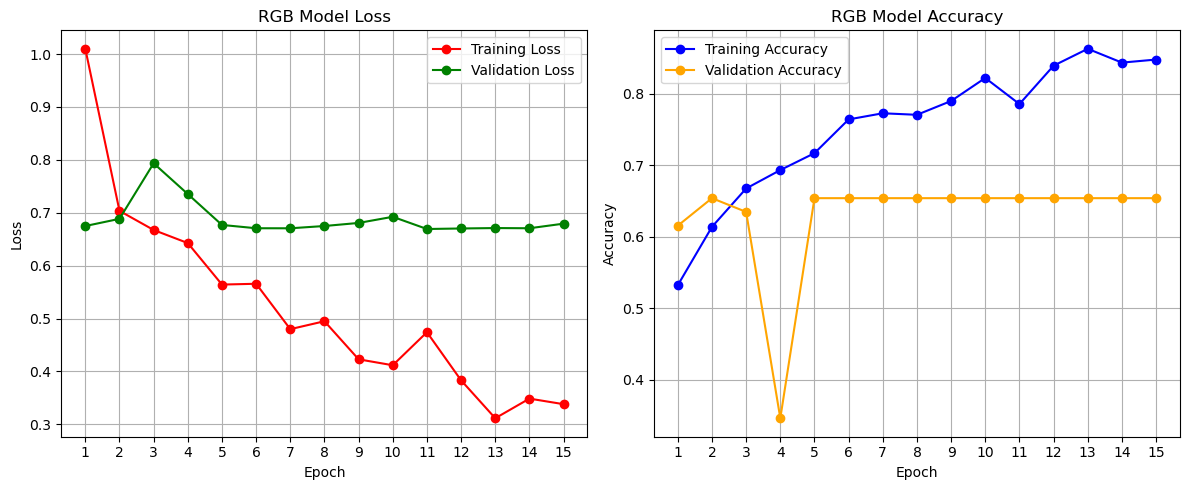

In [4]:
# Separate the losses and accuracies for both training and validation
train_losses = [x[0] for x in train_log]
train_accuracies = [x[1] for x in train_log]

val_losses = [x[0] for x in val_log]
val_accuracies = [x[1] for x in val_log]

# Generate the x-axis values (epochs)
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='r')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='g')
plt.xticks(epochs)
plt.title('RGB Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o', color='b')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.xticks(epochs)
plt.title('RGB Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### RGB Model Confusion Matrix

Train Loss: 0.3116439425850151
Train Accuracy: 86.26609442060087%


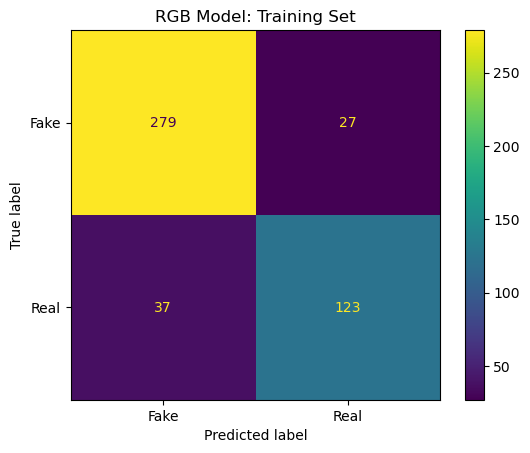

Validation Loss: 0.6711004697359525
Validation Accuracy: 65.38461538461539%


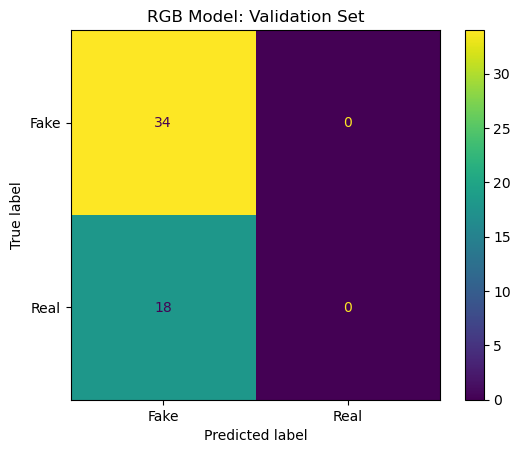

In [6]:
path = "models/s3d_rgb_best_small_v3.pth"

checkpoint = torch.load(path, weights_only=False) #, weights_only=True
# print(checkpoint.keys())
train_cm = checkpoint['train_cm']
val_cm = checkpoint['val_cm']

print(f"Train Loss: {checkpoint['train'][0]}")
print(f"Train Accuracy: {checkpoint['train'][1]*100}%")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = train_cm, display_labels = ['Fake', 'Real'])
cm_display.plot()
cm_display.ax_.set_title('RGB Model: Training Set')
plt.show()

print(f"Validation Loss: {checkpoint['val'][0]}")
print(f"Validation Accuracy: {checkpoint['val'][1]*100}%")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_cm, display_labels = ['Fake', 'Real'])
cm_display.plot()
cm_display.ax_.set_title('RGB Model: Validation Set')
plt.show()

## Flow Dataset

### Train Flow S3D Model

In [2]:
# unfreeze + sgd + scaled + test dataset
dataset_path = "data/Celeb-DF-v2-Flow"
batch_size = 2
epochs = 15
train_log, val_log = train_s3d(dataset_path,batch_size,device,epochs) # 7.8GB 

Training size: 466
Validation size: 52
Input Shape: torch.Size([2, 3, 150, 256, 256])
label Shape: torch.Size([2])
Epoch 1/15
100/233 - Time Taken: 3.12 - train_loss: 0.8252 - train_accuracy: 58.0000%
200/233 - Time Taken: 4.56 - train_loss: 0.8956 - train_accuracy: 51.5000%
233/233 - Time Taken: 9.39 - train_loss: 0.8955 - train_accuracy: 51.9313% - val_loss: 0.7313 - val_accuracy: 63.4615%
Epoch 2/15
100/233 - Time Taken: 4.38 - train_loss: 0.7308 - train_accuracy: 58.5000%
200/233 - Time Taken: 4.25 - train_loss: 0.7535 - train_accuracy: 56.5000%
233/233 - Time Taken: 10.34 - train_loss: 0.7515 - train_accuracy: 55.5794% - val_loss: 0.7333 - val_accuracy: 40.3846%
Epoch 3/15
100/233 - Time Taken: 6.86 - train_loss: 0.6918 - train_accuracy: 61.5000%
200/233 - Time Taken: 2.63 - train_loss: 0.6892 - train_accuracy: 62.2500%
233/233 - Time Taken: 10.42 - train_loss: 0.7043 - train_accuracy: 60.5150% - val_loss: 0.7259 - val_accuracy: 48.0769%
Epoch 4/15
100/233 - Time Taken: 2.55 - tra

### Load Flow Trained Model

In [22]:
path = "models/s3d_flow_last_small_v1.pth"

# replace final layer with new one with appropriate num of classes
# model = s3d(weights=S3D_Weights.DEFAULT)
# model.classifier[1] = nn.Conv3d(1024, 2, kernel_size=1, stride=1)

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

checkpoint = torch.load(path, weights_only=False) #, weights_only=True
print(checkpoint.keys())
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_log = checkpoint['train']
val_log = checkpoint['val']
# train_run = np.array(checkpoint['train_run'])
# train_cm = checkpoint['train_cm']
# val_cm = checkpoint['val_cm']
num_epochs = checkpoint['epoch']

# print(train_log)
# print(val_log)
# print(train_run.shape)
# print(train_run[0])
# print(train_run[1])

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train', 'val', 'train_run', 'train_cm', 'val_cm', 'model'])


### Plot Flow Model Training Results

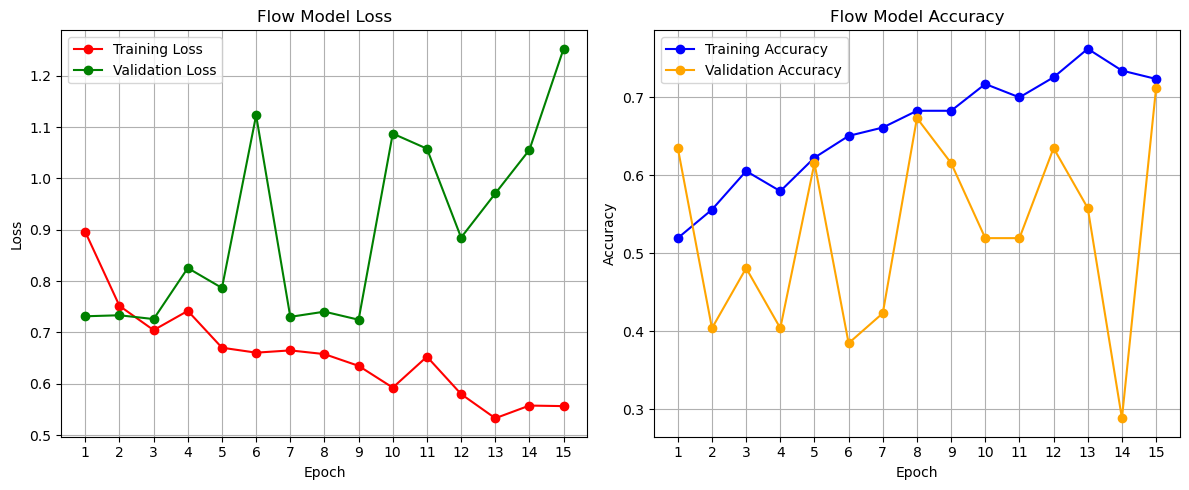

In [23]:
# Separate the losses and accuracies for both training and validation
train_losses = [x[0] for x in train_log]
train_accuracies = [x[1] for x in train_log]

val_losses = [x[0] for x in val_log]
val_accuracies = [x[1] for x in val_log]

# Generate the x-axis values (epochs)
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='r')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='g')
plt.xticks(epochs)
plt.title('Flow Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o', color='b')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.xticks(epochs)
plt.title('Flow Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Flow Model Confusion Matrix

Train Loss: 0.5563023076852376
Train Accuracy: 72.3175965665236%


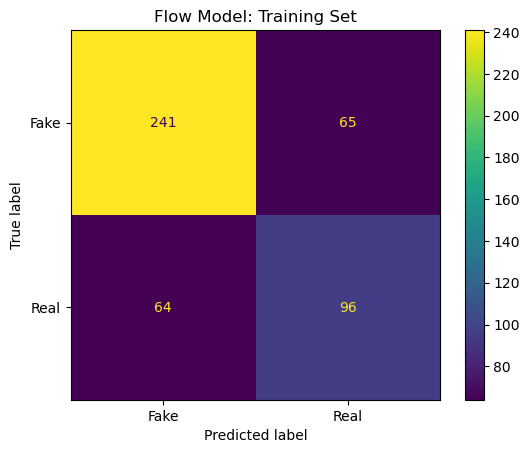

Validation Loss: 1.2523259178090553
Validation Accuracy: 71.15384615384616%


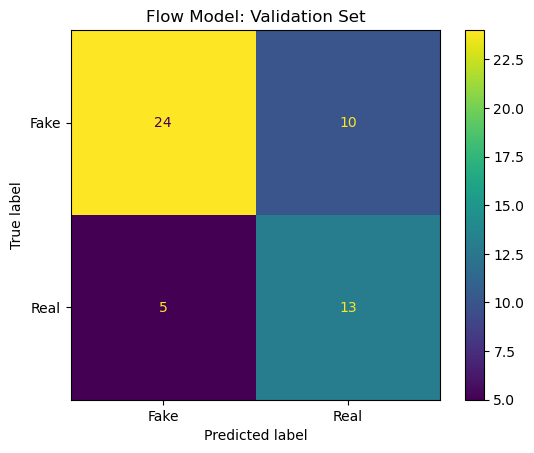

In [8]:
path = "models/s3d_flow_best_small_v1.pth"

checkpoint = torch.load(path, weights_only=False) #, weights_only=True
# print(checkpoint.keys())
train_cm = checkpoint['train_cm']
val_cm = checkpoint['val_cm']

print(f"Train Loss: {checkpoint['train'][0]}")
print(f"Train Accuracy: {checkpoint['train'][1]*100}%")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = train_cm, display_labels = ['Fake', 'Real'])
cm_display.plot()
cm_display.ax_.set_title('Flow Model: Training Set')
plt.show()

print(f"Validation Loss: {checkpoint['val'][0]}")
print(f"Validation Accuracy: {checkpoint['val'][1]*100}%")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_cm, display_labels = ['Fake', 'Real'])
cm_display.plot()
cm_display.ax_.set_title('Flow Model: Validation Set')
plt.show()

## Ensemble

## SadTalker + Real Video Dataset

### Display Example Real Video

In [3]:
dataset_path = Path('data/sadtalkerset')
video_path = "00165.mp4"
# video_path = "00166.mp4"
data_path = dataset_path / video_path

print(data_path)
# Load the video using torchvision
vid, _, _ = read_video(data_path, output_format="TCHW", pts_unit='sec')  # TCHW: Time, Channels, Height, Width
# vid = vid[:32]  # Optionally, shorten the duration if needed (e.g., first 32 frames)
print(vid.shape)

# Display the optical flow image using OpenCV
for frame in vid:
    fr = cv2.cvtColor(frame.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB)
    # print(fr.shape) # 500,892,3
    cv2.imshow('input', fr)
    # Wait for 25ms before moving to the next frame
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break  # Exit the loop if 'q' is pressed

# Release the video window
cv2.destroyAllWindows()

data\sadtalkerset\00166.mp4
torch.Size([469, 3, 500, 892])


### Display Example SadTalker Video

In [4]:
dataset_path = Path('data/sadtalkerset')
# video_path = "fake1.mp4"
video_path = "fake2.mp4"
data_path = dataset_path / video_path

print(data_path)
# Load the video using torchvision
vid, _, _ = read_video(data_path, output_format="TCHW", pts_unit='sec')  # TCHW: Time, Channels, Height, Width
# vid = vid[:32]  # Optionally, shorten the duration if needed (e.g., first 32 frames)
print(vid.shape)

# Display the optical flow image using OpenCV
for frame in vid:
    fr = cv2.cvtColor(frame.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB)
    # print(fr.shape) # 500,892,3
    cv2.imshow('input', fr)
    # Wait for 25ms before moving to the next frame
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break  # Exit the loop if 'q' is pressed

# Release the video window
cv2.destroyAllWindows()

data\sadtalkerset\fake2.mp4
torch.Size([239, 3, 512, 512])


### Inference SadTalker Dataset using RGB Trained Model

Test Dataset Size: 4
Input Shape: torch.Size([1, 3, 150, 256, 256])
label Shape: torch.Size([1])
Test Loss: 1.4699706882238388
Test Accuracy: 0.0


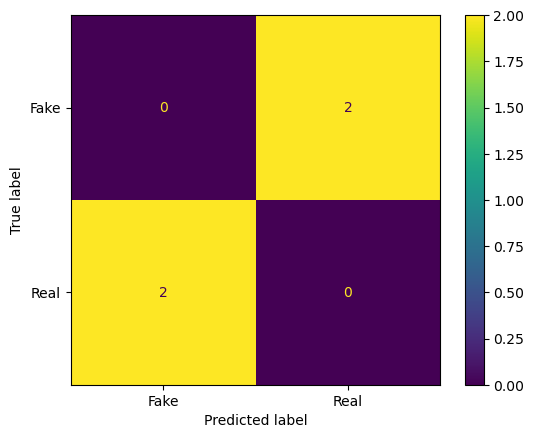

In [2]:
dataset_path = "data/sadtalkerset"
model_path = "models/s3d_rgb_best_small_v3.pth"
batch_size = 4
test_loss, test_accuracy, test_cm = eval_sadtalker(dataset_path,batch_size,device,model_path)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = test_cm, display_labels = ['Fake', 'Real'])

cm_display.plot()
plt.show()

### Inference SadTalker Dataset using Flow Trained Model

#### Generate flow using the flow generation function from earlier section

In [9]:
folder_path = Path('H:/Datasets/maliciousai/data/sadtalkerset')
output_dir = Path('H:/Datasets/maliciousai/data/sadtalkerset-Flow')

process_videos_in_folder(folder_path, raft, output_dir) # 3.8s per video

#### View generated flow from SadTalker video

In [9]:
dataset_path = Path('data/sadtalkerset-Flow')
video_path = "fake1.mp4"
# video_path = "fake2.mp4"
data_path = dataset_path / video_path

print(data_path)
# Load the video using torchvision
vid, _, _ = read_video(data_path, output_format="TCHW", pts_unit='sec')  # TCHW: Time, Channels, Height, Width
# vid = vid[:32]  # Optionally, shorten the duration if needed (e.g., first 32 frames)
print(vid.shape)

# Display the optical flow image using OpenCV
for frame in vid:
    fr = cv2.cvtColor(frame.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB)
    # print(fr.shape) # 500,892,3
    cv2.imshow('input', fr)
    # Wait for 25ms before moving to the next frame
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break  # Exit the loop if 'q' is pressed

# Release the video window
cv2.destroyAllWindows()

data\sadtalkerset-Flow\fake1.mp4
torch.Size([149, 3, 256, 256])


#### Inference using Flow trained model

Test Dataset Size: 4
Input Shape: torch.Size([4, 3, 150, 256, 256])
label Shape: torch.Size([4])
[tensor([[0.8149, 0.1849],
        [0.7109, 0.2888],
        [0.0018, 0.9980],
        [0.5737, 0.4265]], device='cuda:0', dtype=torch.float16)]
[0, 0, 1, 1]
Test Loss: 0.3741052448749542
Test Accuracy: 75.0%


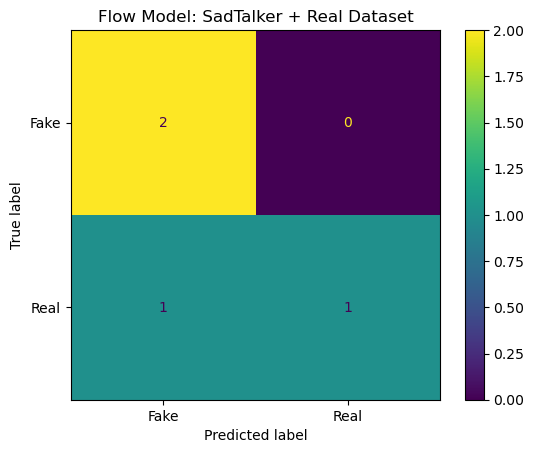

In [2]:
dataset_path = "data/sadtalkerset-Flow"
model_path = "models/s3d_flow_best_small_v1.pth"
batch_size = 4
test_loss, test_accuracy, test_cm = eval_sadtalker(dataset_path,batch_size,device,model_path)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy*100}%")

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = test_cm, display_labels = ['Fake', 'Real'])
cm_display.plot()
cm_display.ax_.set_title('Flow Model: SadTalker + Real Dataset')
plt.show()

### Inference SadTalker Dataset using Ensemble Model

In [3]:
dataset_path1 = "data/sadtalkerset"
model_path1 = "models/s3d_rgb_best_small_v3.pth"

dataset_path2 = "data/sadtalkerset-Flow"
model_path2 = "models/s3d_flow_best_small_v1.pth"
batch_size = 2

# test_loss, test_accuracy, test_cm = 
eval_ensemble(dataset_path1, dataset_path2, batch_size, device, model_path1, model_path2)

# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy*100}%")

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = test_cm, display_labels = ['Fake', 'Real'])
# cm_display.plot()
# cm_display.ax_.set_title('Flow Model: SadTalker + Real Dataset')
# plt.show()

Test Dataset 1 Size: 4
Test Dataset 2 Size: 4
Input Shape: torch.Size([2, 3, 150, 256, 256])
label Shape: torch.Size([2])
2
[tensor([[0.2498, 0.7505],
        [0.0594, 0.9404]], device='cuda:0', dtype=torch.float16), tensor([[0.5659, 0.4341],
        [0.5664, 0.4336]], device='cuda:0', dtype=torch.float16)]
[0, 0, 1, 1]
[tensor([[0.8149, 0.1849],
        [0.7109, 0.2888]], device='cuda:0', dtype=torch.float16), tensor([[0.0018, 0.9980],
        [0.5737, 0.4265]], device='cuda:0', dtype=torch.float16)]
[0, 0, 1, 1]
[tensor([[0.1249, 0.3752],
        [0.0297, 0.4702]], device='cuda:0', dtype=torch.float16), tensor([[0.2830, 0.2170],
        [0.2832, 0.2168]], device='cuda:0', dtype=torch.float16), tensor([[0.4075, 0.0925],
        [0.3555, 0.1444]], device='cuda:0', dtype=torch.float16), tensor([[0.0009, 0.4990],
        [0.2869, 0.2133]], device='cuda:0', dtype=torch.float16)]
